## set-up

In [212]:
import cv2
import subprocess
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage.morphology import skeletonize, thin, opening, square
from skimage.filters import gaussian
from skimage import data

## loading images
Please notice that there are different loading methods depending on the type of images from study 2 (with white backgrounds) and study 3 (with transparent backgrounds). Below, we are working with an example from study 3

In [213]:
# create image file list
def list_files(study):

    # first, specify study
    study = study

    # getting local root of GitHub repository
    repo_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())

    # specify drawing_sample folder
    drawing_samples = repo_root / 'drawing_samples'

    if study == 1: # insert specification for study 1 later
        pass
    elif study == 2:
        study_folder = 'STUDY2_drawing_samples'
    elif study == 3:
        study_folder = 'STUDY3_drawing_samples'

    # specify a file name from that study folder
    file_name = 'Identity_Chain1_Seed4_Gen9.png'

    # we can now assemble the path
    file_path = str(drawing_samples / study_folder / '*')

    # and use glob to construct a list of all paths
    image_path_list = glob.glob(file_path)

    return image_path_list

In [214]:
# now, lets load images from the list, depending on study type
def load_images(study):

    # set up empty image list
    img_list = []

    # load images depending on study number

    if study == 1: # insert specification for study 1 later
        print('no data for study 1 yet')
        pass

    elif study == 2: 

        # load image file names
        file_list = list_files(study = 2)
        
        # load images
        for i in range(len(file_list)):
        
            img = cv2.imread(file_list[i], cv2.IMREAD_GRAYSCALE) # study 2 images are png with white background

            # converting to binary
            img_bin = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY_INV)[1]

            # storing in list
            img_list.append(img_bin)

    elif study == 3: 
        
        # load image file names
        file_list = list_files(study = 3)

        # load images
        for i in range(len(file_list)):

            img = cv2.imread(file_list[i], cv2.IMREAD_UNCHANGED)

            # split channels
            b, g, r, a = cv2.split(img)

            # convert to greyscale; convert transparent pixels to white
            gray = cv2.cvtColor(cv2.merge([b, g, r]), cv2.COLOR_BGR2GRAY)
            gray[a == 0] = 255

            # binarize
            img_bin = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)[1]

            # storing in list
            img_list.append(img_bin)

    return img_list

## Step 1: Fitting line elements within each line via Probabilistic Hough Transform
Documentation: https://scikit-image.org/docs/0.25.x/auto_examples/edges/plot_line_hough_transform.html

Please note that the results are very sensitive to how the parameters of the probabilistic_hough_line() are set. The current combination was reached through trial and error but the accuracy of this setting has not been assessed systematically yet.

In [215]:
# looped probabilistic_hough_line detection - looping over each image creates oversampling, which makes sure all lines are covered; and it seems to improve the clustering as well!
def looped_prob_hough(image, n_loops = 15, treshold = 30, line_length = 190, line_gap = 0, plot = False):

    n_loops = n_loops

    image = image

    all_lines = []

    for seed in range(n_loops):
        np.random.seed(seed)
        lines = probabilistic_hough_line(image,
                                        threshold=treshold,
                                        line_length=line_length,
                                        line_gap=line_gap)
        all_lines.extend(lines)

    lines = all_lines

    # plotting lines
    if plot == True:

        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(image, cmap=cm.gray)
        ax[0].set_title('Input line drawing')

        ax[1].imshow(image, cmap=cm.gray)
        for line in lines:
            p0, p1 = line
            ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
        ax[1].set_xlim((0, image.shape[1]))
        ax[1].set_ylim((image.shape[0], 0))
        ax[1].set_title('Probabilistic Hough juxtaposed')

        for line in lines:
            p0, p1 = line
            ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
        ax[2].set_xlim((0, image.shape[1]))
        ax[2].set_ylim((image.shape[0], 0))
        ax[2].set_title('Probabilistic Hough lines')

        ax[2].set_xlim(0,400)
        ax[2].set_ylim(400,0)
        ax[2].set_aspect('equal') 

        for a in ax:
            a.set_axis_off()

        plt.figure()
        plt.tight_layout()
        plt.show()
    
    return lines

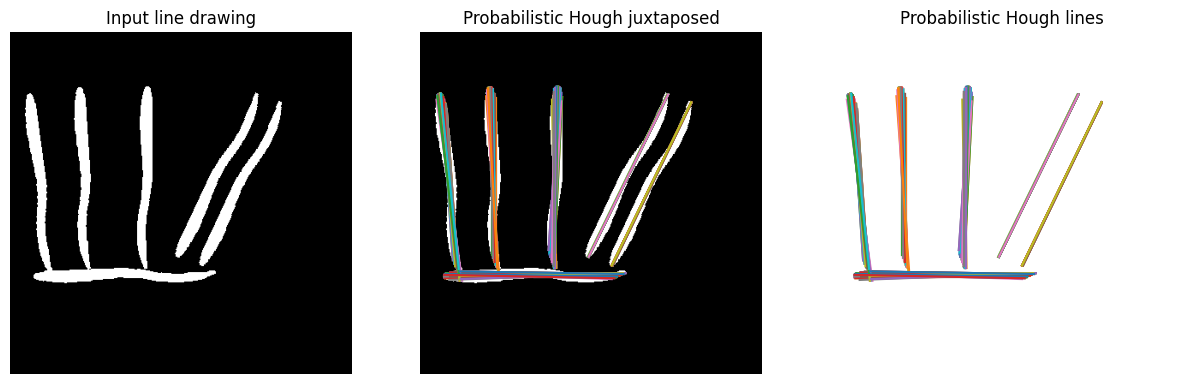

<Figure size 640x480 with 0 Axes>

In [222]:
# we can now use the function, passing a file from the study_image_list as input
img_study = load_images(study = 3)
image = img_study[2]
lines = looped_prob_hough(image = image, n_loops = 15, plot = True)

## Step 2: Creating line representations for clustering

Here, some features of all sublines are computed and stored as a new data structure. 

The idea is to be able to cluster the linesegments within each actual line based on their midpoints and orientations, following the rationale that sublines with very similar midpoints and orientations will belong to the same actual line.

In [223]:
##### method using terminal points

# unnesting the terminal point coordinates for each line (to make each line a single tupple)
line_term_tupples = [(x1, y1, x2, y2) for ((x1, y1), (x2, y2)) in lines]

# turning it into a dataframe
line_term_tupples_df = pd.DataFrame(data = line_term_tupples, columns=['x_1', 'y_1', 'x_2', 'y_2'])
line_term_tupples_df.head()

,x_1,y_1,x_2,y_2
0,89,274,82,65
1,159,276,156,73
2,224,273,317,83
3,46,291,23,72
4,238,283,46,280


## Step 3: Clustering (labelling) sublines

This part of the script is still very much a work in progress. The idea is to use clustering algorithms to group the lines. Immediate results seem very mixed.

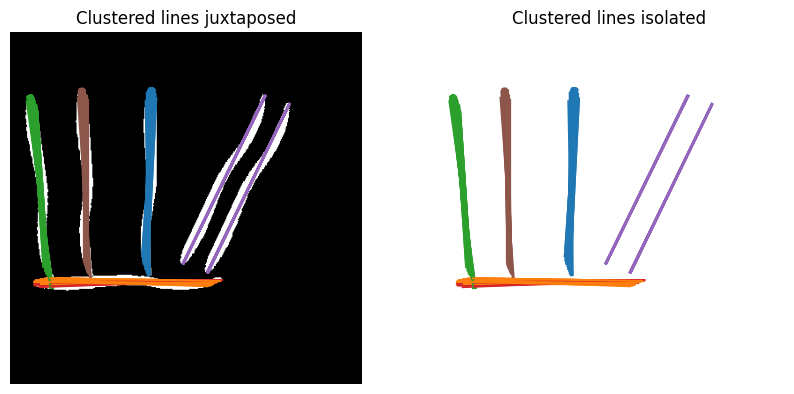

In [250]:
# approach using terminal points and K-means

# clustering the lines using KMeans
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
kmeans.fit(line_term_tupples_df)

# adding the clustering information to a new line dataframe
clustered_lines = line_term_tupples_df
clustered_lines['cluster_labels'] = kmeans.labels_[:]

# clustered_lines.head()

# plotting lines colored by label
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Clustered lines juxtaposed')

for _, row in clustered_lines.iterrows():
    ax[0].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')
    
# plotting lines without juxtaposition
ax[1].set_title('Clustered lines isolated')

for _, row in clustered_lines.iterrows():
    ax[1].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')
ax[1].set_xlim(0,400)
ax[1].set_ylim(400,0)
ax[1].set_aspect('equal') 

for a in ax:
    a.set_axis_off()

plt.show()

## Trying out hessian version

In [225]:
def endpoints_to_hesse(df, x1="x_1", y1="y_1", x2="x_2", y2="y_2"):
    x1v = df[x1].values
    y1v = df[y1].values
    x2v = df[x2].values
    y2v = df[y2].values

    dx = x2v - x1v
    dy = y2v - y1v
    L = np.hypot(dx, dy)
    L[L == 0] = np.nan

    # unit normal
    nx =  dy / L
    ny = -dx / L

    # angle
    theta = np.mod(np.arctan2(ny, nx), np.pi)

    # signed distance
    rho = x1v * nx + y1v * ny

    # enforce rho >= 0
    flip = rho < 0
    rho[flip] *= -1
    theta[flip] = np.mod(theta[flip] + np.pi/2, np.pi)

    df_out = df.copy()
    df_out["theta"] = theta
    df_out["rho"] = rho
    return df_out


In [226]:
# converting to hesse form
line_term_tupples_df.pop('cluster_labels')
hesse_df = endpoints_to_hesse(df = line_term_tupples_df)

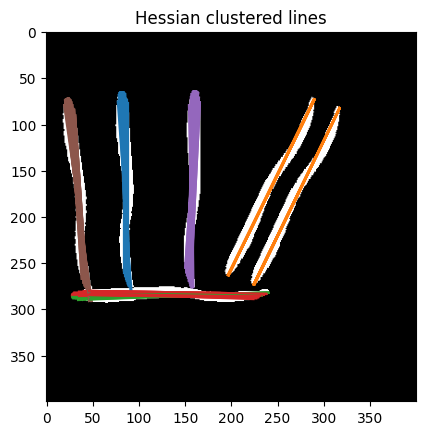

In [229]:
# trying clustering on this new representation

# cluster
n_lines = 6
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
kmeans.fit(hesse_df)

# adding the clustering information to a new line dataframe
clustered_lines = hesse_df
clustered_lines['cluster_labels'] = kmeans.labels_[:]

# plotting lines colored by label
fig, ax = plt.subplots()
ax.imshow(image, cmap=cm.gray)
ax.set_title('Hessian clustered lines')

for _, row in clustered_lines.iterrows():
    ax.plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')
plt.show()

## Step 4: Find average lines

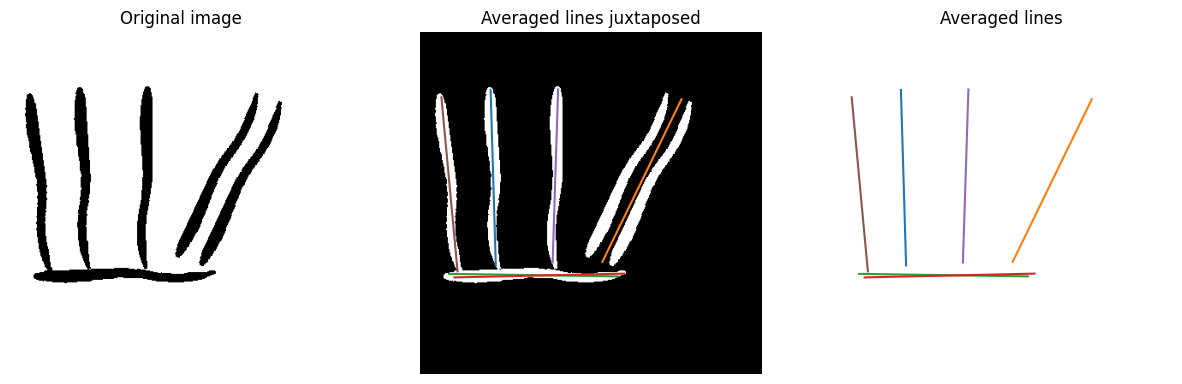

In [ ]:
# define averaging method
method = 'mean'

# finding average lines
avg_lines = clustered_lines.groupby('cluster_labels').agg({
    'x_1': method,
    'y_1': method,
    'x_2': method,
    'y_2': method,
    'cluster_labels': 'first',
})

# plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].imshow(1-image, cmap=cm.gray)
ax[0].set_title('Original image')

# plotting lines on top of image
ax[1].imshow(image, cmap=cm.gray)
ax[1].set_title('Averaged lines juxtaposed')

for _, row in avg_lines.iterrows():
    ax[1].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')

# plotting without image
ax[2].set_title('Averaged lines')

for _, row in avg_lines.iterrows():
    ax[2].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')

ax[2].set_xlim(0,400)
ax[2].set_ylim(400,0)
ax[2].set_aspect('equal') 

for a in ax:
    a.set_axis_off()

plt.show()